In [1]:
import contextlib
import io

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 

pd.set_option('display.float_format', lambda x: '%.1f' % x)
np.set_printoptions(precision=2)

from scipy.interpolate import interp1d

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout, BatchNormalization, Concatenate, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.regularizers import l2

import joblib
import ast

In [2]:
def split_dataframe(df, train_size=0.7, val_size=0.2):
    """
    Découpe un DataFrame temporel en trois parties : train, val, test,
    en respectant l'ordre chronologique.

    Args:
        df (pd.DataFrame): Données à découper (indexé ou non par le temps)
        train_size (float): Proportion pour l'ensemble d'entraînement
        val_size (float): Proportion pour la validation

    Returns:
        df_train, df_val, df_test (DataFrames)
    """
    df = df.copy()
    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    print(f"Train size : {len(df_train)}")
    print(f"Val size : {len(df_val)}")
    print(f"Test size : {len(df_test)}")

    return df_train.copy(), df_val.copy(), df_test.copy()

In [3]:
def evaluate_model(y_true, y_pred):
    """
    Calcule et affiche les métriques MAE, RMSE et R² entre les vraies valeurs et les prédictions.

    Args:
        y_true (array-like): Valeurs réelles.
        y_pred (array-like): Valeurs prédites.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    return {"MAE":mae, "RMSE":rmse, "R2 Score":r2}

In [4]:
def create_dataset(X, y, time_steps=1):  
    Xs, ys = [], []   
    for i in range(len(X) - time_steps):   
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)      
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

    """
This function prepares the input features and target values in the format required for training a recurrent neural network (RNN) or LSTM model for sequential prediction tasks. It creates sequences of input features and their corresponding target values, which can be fed into the model during training.

    - X: This parameter represents the input features, typically a pandas DataFrame containing multiple time-series variables such as temperature, humidity, etc.
    - y: This parameter represents the target values, which are typically the values we want to predict based on the input features.
    - time_steps: This parameter defines the length of each sequence. It determines how many data points from the past will be used to predict the next data point. For example, if time_steps is set to 3, the function will create sequences of three consecutive data points as input features and the next data point as the target value.
    """

In [5]:
def build_and_train_bilstm(X_train, y_train, X_val, y_val, sequence_length, units=100, 
                           activation='tanh', epochs=30, batch_size=32, patience=10):
    """
    Construit, entraîne et évalue un modèle BiLSTM avec early stopping.

    Args:
        X_train (ndarray): Données d'entraînement (3D).
        y_train (ndarray): Cibles d'entraînement.
        X_val (ndarray): Données de validation (3D).
        y_val (ndarray): Cibles de validation.
        sequence_length (int): Longueur des séquences en entrée.
        units (int): Nombre de neurones dans la couche LSTM.
        activation (str): Fonction d'activation de la couche LSTM.
        epochs (int): Nombre d’époques d’entraînement.
        batch_size (int): Taille de lot pour l’entraînement.
        patience (int): Patience pour l’early stopping.

    Returns:
        model: Le modèle entraîné.
        history: L'historique d'entraînement.
        val_loss: La perte de validation finale.
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation=activation, input_shape=(sequence_length, X_train.shape[2]))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    display(f'Validation Loss: {val_loss}')

    return model, history, val_loss


In [6]:
def train_temperature_model(X, y, epochs=100, batch_size=32, validation_split=0.2):
    """
    Construit, compile et entraîne un modèle Keras pour prédire 24 températures horaires.

    Paramètres
    ----------
    X : ndarray shape (n_samples, n_features)
        Tableau des caractéristiques d’entrée (ex. Tmin, Tmoy, Tmax, jour_annee, mois).
    y : ndarray shape (n_samples, n_outputs)
        Tableau des cibles (24 températures horaires).
    epochs : int, optional (default=100)
        Nombre d’époques d’entraînement.
    batch_size : int, optional (default=32)
        Taille du batch.
    validation_split : float, optional (default=0.2)
        Fraction des données réservée à la validation.

    Retour
    ------
    model : keras.Model
        Le modèle entraîné.
    history : keras.callbacks.History
        L’historique d’entraînement (pertes et métriques).
    """
    input_dim  = X.shape[1]
    output_dim = y.shape[1]

    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(output_dim)                         # régression, donc pas d’activation finale
    ])

    model.compile(optimizer=Adam(),
                  loss='mse',
                  metrics=['mae'])

    history = model.fit(X, y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1)

    return model, history

In [7]:
def load_data_drias(path_fichier_excel):
    """
    Charge un fichier Excel DRIAS avec une colonne 'Date' au format '%d/%m/%Y',
    et retourne un DataFrame avec la date en index.

    Args:
        path_fichier_excel (str): Chemin vers le fichier Excel.

    Returns:
        pd.DataFrame: Données DRIAS avec l'index daté.
    """
    df = pd.read_excel(path_fichier_excel)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.set_index('Date', inplace=True)
    display(df)
    
    return df

In [8]:
def predict_and_inverse_transform(model, X, y, target_transformer):
    """
    Effectue la prédiction avec le modèle donné et applique l'inverse de la transformation 
    sur les prédictions et les vraies valeurs cibles.

    Args:
        model: Modèle entraîné (ex. BiLSTM).
        X_val: Données d'entrée de validation.
        y_val: Vraies valeurs cibles de validation.
        target_transformer: Transformateur utilisé pour normaliser les cibles (ex. MinMaxScaler).

    Returns:
        Tuple (y_pred_original_scale, y_true_original_scale)
    """
    # Prédiction
    y_pred = model.predict(X)

    # Inversion de la transformation des prédictions
    y_pred_inv = target_transformer.inverse_transform(y_pred)

    # Reshape puis inversion de la transformation des vraies valeurs
    y = y.reshape(-1, 1)
    y_val_inv = target_transformer.inverse_transform(y)

    return y_pred_inv, y_val_inv

In [9]:
def convertir_q_en_rh(q_kgkg, temperature_C, pression_hPa=1013.25):
    """
    Convertit une série d'humidité spécifique (kg/kg) et de température (°C)
    en humidité relative (%) en supposant une pression constante.

    Paramètres :
        q_kgkg : pd.Series ou np.array d'humidité spécifique (kg/kg)
        temperature_C : pd.Series ou np.array de température (°C)
        pression_hPa : pression atmosphérique en hPa (par défaut = 1013.25)

    Retour :
        pd.Series ou np.array d'humidité relative (%) — même type que l'entrée
    """
    q = np.asarray(q_kgkg)
    T = np.asarray(temperature_C)

    # Pression partielle de vapeur d'eau (e) [hPa]
    e = (q * pression_hPa) / (0.622 + 0.378 * q)

    # Pression de vapeur saturante (e_s) [hPa] — formule de Tetens
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))

    # Humidité relative RH [%]
    RH = 100 * e / e_s
    RH = np.clip(RH, 0, 100)

    # Renvoyer dans le même format que l'entrée
    if isinstance(q_kgkg, pd.Series):
        return pd.Series(RH, index=q_kgkg.index, name='RH_%')
    else:
        return RH
    
    
def calculate_relative_humidity(tmean, huss):
    """
    Calcule l'humidité relative (hr) en % à partir des données :
    - tasmin : température minimale journalière à 2m (°C)
    - tasmax : température maximale journalière à 2m (°C)
    - huss   : humidité spécifique à 2m (g/kg)

    Toutes les entrées peuvent être scalaires, des tableaux NumPy ou des colonnes pandas.
    """

    # 2. Pression de vapeur de saturation psat (en hPa)
    psat = np.where(
        tmean < 0,
        10 ** (2.7862 + (9.7561 * tmean) / (272.67 + tmean)),
        10 ** (2.7862 + (7.5526 * tmean) / (239.21 + tmean))
    )

    # 3. Calcul de l’humidité relative en pourcentage
    hr = (huss / 0.622) / psat * 10000
    hr = np.minimum(hr, 100)  # Limiter à 100 %

    return hr

In [10]:
def convertir_humidite_kgkg_en_gkg(serie_kgkg):
    """
    Convertit une série Pandas d'humidité spécifique de kg/kg en g/kg.
    
    Paramètres :
    - serie_kgkg : pd.Series contenant des valeurs en kg/kg
    
    Retour :
    - pd.Series contenant les valeurs converties en g/kg
    """
    return serie_kgkg * 1000

In [11]:
def extract_24h_values(group):
    if len(group) == 24:
        return group.values
    else:
        print(group)

##### **Dataset DRIAS RCP**

In [12]:
data_rcp_2_6 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp2.6_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.6,-0.0,0.0,0.0,0.0,53.7,265.0,2.2,0.2
2006-01-02,49.2,4.0,0.2,4.0,2.1,8.8,1.0,0.0,9.2,344.0,7.1,0.1
2006-01-03,49.2,4.0,8.6,9.2,9.0,0.7,0.0,0.0,7.5,382.9,8.3,0.2
2006-01-04,49.2,4.0,9.9,14.2,12.7,0.5,0.0,0.0,19.2,356.6,5.4,0.4
2006-01-05,49.2,4.0,7.6,11.5,9.0,0.0,0.0,0.0,14.2,367.9,2.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,0.7,4.6,2.6,0.0,0.0,0.0,53.9,263.4,3.4,0.6
2100-12-28,49.2,4.0,-0.7,2.5,0.7,1.0,0.6,0.0,12.9,314.8,3.8,0.4
2100-12-29,49.2,4.0,-1.1,1.2,-0.2,0.4,0.4,0.0,18.2,310.8,1.2,0.2


In [13]:
data_rcp_2_6.isnull().sum()

Latitude            0
Longitude           0
tasminAdjust        0
tasmaxAdjust        0
tasAdjust           0
prtotAdjust         0
prsnAdjust          0
hussAdjust          0
rsdsAdjust          0
rldsAdjust          0
sfcWindAdjust       0
evspsblpotAdjust    0
dtype: int64

In [14]:
data_rcp_4_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.7,-0.0,0.2,0.2,3.5,53.2,264.9,7.7,0.2
2006-01-02,49.2,4.0,0.0,4.1,2.0,8.4,1.0,5.0,9.1,347.3,25.2,0.0
2006-01-03,49.2,4.0,8.6,9.0,8.8,0.7,0.0,8.2,8.8,381.7,30.1,0.2
2006-01-04,49.2,4.0,9.8,13.1,11.9,0.1,0.0,7.8,16.8,355.5,20.9,0.5
2006-01-05,49.2,4.0,5.2,11.0,7.2,0.0,0.0,6.1,29.1,338.0,5.6,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,1.0,9.5,4.5,0.0,0.0,5.0,51.6,286.6,11.4,0.2
2100-12-28,49.2,4.0,4.1,12.0,8.3,3.6,0.0,5.9,38.1,319.0,14.5,0.4
2100-12-29,49.2,4.0,4.6,9.6,8.1,2.7,0.0,5.2,30.5,324.1,15.7,0.6


In [15]:
data_rcp_4_5.isnull().sum()

Latitude            0
Longitude           0
tasminAdjust        0
tasmaxAdjust        0
tasAdjust           0
prtotAdjust         0
prsnAdjust          0
hussAdjust          0
rsdsAdjust          0
rldsAdjust          0
sfcWindAdjust       0
evspsblpotAdjust    0
dtype: int64

In [16]:
data_rcp_8_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp8.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.6,-0.1,0.0,0.0,3.5,53.7,264.9,7.9,0.2
2006-01-02,49.2,4.0,0.1,4.0,2.0,8.6,1.1,5.0,9.5,344.4,25.1,0.0
2006-01-03,49.2,4.0,8.6,8.9,8.7,0.7,0.0,8.2,8.2,381.6,30.0,0.2
2006-01-04,49.2,4.0,9.8,12.3,11.4,0.1,0.0,8.0,16.0,357.1,21.4,0.2
2006-01-05,49.2,4.0,7.1,10.8,8.4,0.0,0.0,6.5,13.6,365.0,7.5,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,-0.7,6.1,1.6,0.1,0.0,3.1,51.8,285.6,7.6,0.5
2100-12-28,49.2,4.0,1.8,4.4,3.0,0.3,0.0,4.7,21.3,340.2,1.7,0.1
2100-12-29,49.2,4.0,2.2,6.7,5.2,0.5,0.1,4.9,17.4,343.0,9.0,0.2


##### **Dataset Prunay**
🌦️ Description des colonnes - Station météo Reims - Prunay

In [17]:
data_prunay = pd.read_csv('Atmo/reims_hourly_2007_2025.csv')
data_prunay

,time,temperature_2m,relative_humidity_2m,pressure_msl,precipitation,wind_speed_10m
0,2007-01-01 00:00:00,11.8,91.0,1019.5,1.0,28.4
1,2007-01-01 01:00:00,11.7,93.0,1018.8,2.2,30.7
2,2007-01-01 02:00:00,12.0,91.0,1017.8,1.4,34.6
3,2007-01-01 03:00:00,12.3,90.0,1017.6,0.4,35.4
4,2007-01-01 04:00:00,12.3,90.0,1017.6,0.6,32.2
...,...,...,...,...,...,...
162643,2025-07-21 19:00:00,NaN,NaN,NaN,NaN,NaN
162644,2025-07-21 20:00:00,NaN,NaN,NaN,NaN,NaN
162645,2025-07-21 21:00:00,NaN,NaN,NaN,NaN,NaN
162646,2025-07-21 22:00:00,NaN,NaN,NaN,NaN,NaN


In [18]:
data_prunay['time'] = pd.to_datetime(data_prunay['time'], format='%Y-%m-%d %H:%M:%S')
data_prunay.set_index('time', inplace=True)
data_prunay

,temperature_2m,relative_humidity_2m,pressure_msl,precipitation,wind_speed_10m
time,,,,,
2007-01-01 00:00:00,11.8,91.0,1019.5,1.0,28.4
2007-01-01 01:00:00,11.7,93.0,1018.8,2.2,30.7
2007-01-01 02:00:00,12.0,91.0,1017.8,1.4,34.6
2007-01-01 03:00:00,12.3,90.0,1017.6,0.4,35.4
2007-01-01 04:00:00,12.3,90.0,1017.6,0.6,32.2
...,...,...,...,...,...
2025-07-21 19:00:00,NaN,NaN,NaN,NaN,NaN
2025-07-21 20:00:00,NaN,NaN,NaN,NaN,NaN
2025-07-21 21:00:00,NaN,NaN,NaN,NaN,NaN


In [19]:
# récupérer les index communs data rcp2.6
common_index_data_rcp_2_6 = data_rcp_2_6.index.intersection(data_prunay.index)
data_rcp_2_6_ = data_rcp_2_6.loc[common_index_data_rcp_2_6]

In [20]:
# récupérer les index communs data rcp4.5
common_index_data_rcp_4_5 = data_rcp_4_5.index.intersection(data_prunay.index)
data_rcp_4_5_ = data_rcp_4_5.loc[common_index_data_rcp_4_5]

In [21]:
# récupérer les index communs data rcp8.5
common_index_data_rcp_8_5 = data_rcp_8_5.index.intersection(data_prunay.index)
data_rcp_8_5_ = data_rcp_8_5.loc[common_index_data_rcp_8_5]

In [22]:
data_prunay = data_prunay[["temperature_2m", "relative_humidity_2m", "precipitation"]].copy()
data_prunay.rename(columns={"relative_humidity_2m": "prunay_RH"}, inplace=True)
data_prunay.rename(columns={"temperature_2m": "prunay_Temperature"}, inplace=True)
data_prunay.rename(columns={"precipitation": "prunay_Precipitation"}, inplace=True)
data_prunay = data_prunay[~data_prunay.index.duplicated(keep='first')]
data_prunay.dropna(inplace=True)
RH = convertir_q_en_rh(data_rcp_2_6["hussAdjust"], data_rcp_2_6["tasAdjust"])
data_rcp_2_6["rcp_RH"] = RH

In [23]:
data_prunay

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-01 00:00:00,11.8,91.0,1.0
2007-01-01 01:00:00,11.7,93.0,2.2
2007-01-01 02:00:00,12.0,91.0,1.4
2007-01-01 03:00:00,12.3,90.0,0.4
2007-01-01 04:00:00,12.3,90.0,0.6
...,...,...,...
2025-07-20 22:00:00,19.8,69.0,0.0
2025-07-20 23:00:00,18.6,74.0,0.0
2025-07-21 00:00:00,17.9,75.0,0.0


In [24]:
data_prunay_hourly_predict = data_prunay.copy()

In [25]:
data_rcp_2_6

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust,rcp_RH
Date,,,,,,,,,,,,,
2006-01-01,49.2,4.0,-3.1,4.6,-0.0,0.0,0.0,0.0,53.7,265.0,2.2,0.2,93.6
2006-01-02,49.2,4.0,0.2,4.0,2.1,8.8,1.0,0.0,9.2,344.0,7.1,0.1,100.0
2006-01-03,49.2,4.0,8.6,9.2,9.0,0.7,0.0,0.0,7.5,382.9,8.3,0.2,100.0
2006-01-04,49.2,4.0,9.9,14.2,12.7,0.5,0.0,0.0,19.2,356.6,5.4,0.4,90.0
2006-01-05,49.2,4.0,7.6,11.5,9.0,0.0,0.0,0.0,14.2,367.9,2.0,0.3,95.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,49.2,4.0,0.7,4.6,2.6,0.0,0.0,0.0,53.9,263.4,3.4,0.6,77.2
2100-12-28,49.2,4.0,-0.7,2.5,0.7,1.0,0.6,0.0,12.9,314.8,3.8,0.4,85.5
2100-12-29,49.2,4.0,-1.1,1.2,-0.2,0.4,0.4,0.0,18.2,310.8,1.2,0.2,95.3


In [26]:
data_prunay_hourly_predict

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-01 00:00:00,11.8,91.0,1.0
2007-01-01 01:00:00,11.7,93.0,2.2
2007-01-01 02:00:00,12.0,91.0,1.4
2007-01-01 03:00:00,12.3,90.0,0.4
2007-01-01 04:00:00,12.3,90.0,0.6
...,...,...,...
2025-07-20 22:00:00,19.8,69.0,0.0
2025-07-20 23:00:00,18.6,74.0,0.0
2025-07-21 00:00:00,17.9,75.0,0.0


In [27]:
data_prunay_hourly_temp_predict = data_prunay_hourly_predict["prunay_Temperature"].copy()

In [28]:
data_prunay_hourly_hr_predict = data_prunay_hourly_predict.copy()

In [29]:
data_prunay_hourly_temp_predict = data_prunay_hourly_temp_predict.resample('D').agg(['min', 'mean', 'max'])

In [30]:
data_prunay_hourly_hr_predict = data_prunay_hourly_hr_predict.resample('D').agg({
    'prunay_RH': ['mean'],
    'prunay_Temperature': ['min', 'mean', 'max'],
    'prunay_Precipitation' : ['mean']
})

In [31]:
data_prunay_hourly_hr_predict.columns = ['{}_{}'.format(col[0], col[1]) for col in data_prunay_hourly_hr_predict.columns]

In [32]:
data_prunay_hourly_temp_predict["day_of_year"] = data_prunay_hourly_temp_predict.index.dayofyear
data_prunay_hourly_temp_predict["month"] = data_prunay_hourly_temp_predict.index.month

In [33]:
data_prunay_hourly_hr_predict["day_of_year"] = data_prunay_hourly_hr_predict.index.dayofyear
data_prunay_hourly_hr_predict["month"] = data_prunay_hourly_hr_predict.index.month

In [34]:
data_prunay_hourly_hr_predict

,prunay_RH_mean,prunay_Temperature_min,prunay_Temperature_mean,prunay_Temperature_max,prunay_Precipitation_mean,day_of_year,month
time,,,,,,,
2007-01-01,80.4,6.0,9.3,12.3,0.3,1,1
2007-01-02,86.6,4.0,5.3,6.7,0.3,2,1
2007-01-03,91.8,4.3,5.5,6.9,0.0,3,1
2007-01-04,87.0,6.7,8.1,9.8,0.1,4,1
2007-01-05,86.2,7.3,8.5,9.6,0.0,5,1
...,...,...,...,...,...,...,...
2025-07-17,69.7,13.7,19.9,25.4,0.0,198,7
2025-07-18,62.3,16.2,23.0,28.7,0.0,199,7
2025-07-19,64.5,18.8,22.4,27.4,0.0,200,7


In [35]:
data_prunay_hourly_temp_predict

,min,mean,max,day_of_year,month
time,,,,,
2007-01-01,6.0,9.3,12.3,1,1
2007-01-02,4.0,5.3,6.7,2,1
2007-01-03,4.3,5.5,6.9,3,1
2007-01-04,6.7,8.1,9.8,4,1
2007-01-05,7.3,8.5,9.6,5,1
...,...,...,...,...,...
2025-07-17,13.7,19.9,25.4,198,7
2025-07-18,16.2,23.0,28.7,199,7
2025-07-19,18.8,22.4,27.4,200,7


In [36]:
y_temp= data_prunay["prunay_Temperature"].resample('D').apply(extract_24h_values)

time
2025-07-21 00:00:00   17.9
2025-07-21 01:00:00   17.5
2025-07-21 02:00:00   17.3
Name: 2025-07-21 00:00:00, dtype: float64


In [37]:
y_rh = data_prunay["prunay_RH"].resample('D').apply(extract_24h_values)

time
2025-07-21 00:00:00   75.0
2025-07-21 01:00:00   75.0
2025-07-21 02:00:00   75.0
Name: 2025-07-21 00:00:00, dtype: float64


In [38]:
data_prunay_hourly_temp_predict["y"] = y_temp

In [39]:
data_prunay_hourly_hr_predict["y"] = y_rh

In [40]:
data_prunay_hourly_temp_predict.dropna(inplace=True)

In [41]:
data_prunay_hourly_hr_predict.dropna(inplace=True)

In [42]:
def preprocess_data(df, features, pred):
    # Transformation cyclique pour les caractéristiques temporelles
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Cible - conversion en matrice 2D (n_jours × 24_heures)
    y = np.vstack(df['y'].values)
    
    # Normalisation
    if pred == "temp":
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
        
    if pred == "hr":
        X_scaler = StandardScaler()
        y_scaler = MinMaxScaler()
        
    X = X_scaler.fit_transform(df[features])
    y = y_scaler.fit_transform(y)
    
    return X, y, X_scaler, y_scaler, features

In [43]:
class TanhRange(Layer):
    def __init__(self, min_val=0, max_val=100, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
    
    def call(self, inputs):
        tanh = tf.tanh(inputs)  # [-1, 1]
        scaled = (tanh + 1) / 2  # [0, 1]
        return scaled * (self.max_val - self.min_val) + self.min_val
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "min_val": self.min_val,
            "max_val": self.max_val
        })
        return config


def build_model(input_dim, pred):
    model = Sequential([
        Dense(256, activation='relu', 
              kernel_initializer='he_normal',
              kernel_regularizer=l2(0.001),
              input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu', 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        Dense(24),  # 24 sorties pour les données horaires
    ])
    
    if pred=="hr":
        model.add(TanhRange(min_val=0, max_val=100)) # Couche personnalisée ajoutée ici
    
    optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    
    model.summary()
    return model

In [44]:
# Entraînement avec validation temporelle
def train_model(X, y, pred):
    # Séparation temporelle (plus adaptée pour les données chronologiques)
    tscv = TimeSeriesSplit(n_splits=5)
    
    best_val_loss = float('inf')
    best_model = None
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"\nEntraînement fold {fold+1}/{tscv.get_n_splits()}")
        print(f"Taille train: {len(train_index)}, validation: {len(val_index)}")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = build_model(X.shape[1], pred)
        
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=16,
            callbacks=callbacks,
            verbose=1
        )
        
        # Sauvegarder le meilleur modèle
        val_loss = min(history.history['val_loss'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            print(f"Nouveau meilleur modèle avec val_loss = {val_loss:.4f}")
    
    return best_model

In [45]:
def evaluate_model(model, X_test, y_test, y_scaler, pred):
    # Dénormalisation
    y_test_actual = y_scaler.inverse_transform(y_test)
    y_pred = y_scaler.inverse_transform(model.predict(X_test))
    
    # Calcul MAE par heure
    hourly_mae = np.mean(np.abs(y_pred - y_test_actual), axis=0)
    
    # Visualisation
    plt.figure(figsize=(14, 6))
    
    # MAE par heure
    plt.subplot(1, 2, 1)
    plt.bar(range(24), hourly_mae, color='skyblue')
    plt.title('Erreur Moyenne Absolue (MAE) par heure')
    plt.xlabel('Heure de la journée')
    plt.ylabel('MAE')
    plt.xticks(range(24), [f'{h:02d}h' for h in range(24)], rotation=45)
    plt.grid(alpha=0.3)
    
    # Comparaison sur un échantillon
    sample_idx = np.random.randint(len(X_test))
    plt.subplot(1, 2, 2)
    plt.plot(y_test_actual[sample_idx], 'o-', label='Valeurs réelles', linewidth=2)
    plt.plot(y_pred[sample_idx], 's-', label='Prédictions', linewidth=1.5)
    plt.title(f'Prédictions vs Réelles - Jour aléatoire')
    plt.xlabel('Heure')
    plt.ylabel('Temp(°C) / HR(%)')
    plt.legend()
    plt.xticks(range(0, 24, 3), [f'{h:02d}h' for h in range(0, 24, 3)])
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300)
    plt.show()
    
    if pred == "temp":
        print(f"\nPerformance du modèle:")
        print(f"MAE moyen: {np.mean(hourly_mae):.4f}°C")
        print(f"MAE max (à {np.argmax(hourly_mae):02d}h): {np.max(hourly_mae):.4f}°C")
        print(f"MAE min (à {np.argmin(hourly_mae):02d}h): {np.min(hourly_mae):.4f}°C")
    if pred == "hr":
        print(f"\nPerformance du modèle:")
        print(f"MAE moyen: {np.mean(hourly_mae):.4f}%")
        print(f"MAE max (à {np.argmax(hourly_mae):02d}h): {np.max(hourly_mae):.4f}%")
        print(f"MAE min (à {np.argmin(hourly_mae):02d}h): {np.min(hourly_mae):.4f}%")
    
    return hourly_mae

In [46]:
def train_and_evaluate_model_temporal_split(X, y, y_scaler, train_model, evaluate_model, test_size=0.2, pred="temp"):
    """
    Entraîne et évalue un modèle de prédiction de température avec validation temporelle
    
    Args:
        X (np.array): Features normalisées
        y (np.array): Cibles normalisées 
        y_scaler (StandardScaler): Scaler pour la dénormalisation des cibles
        test_size (float): Proportion des données à utiliser pour le test (0.0-1.0)
        
    Returns:
        model (keras.Model): Modèle entraîné
        hourly_mae (np.array): MAE par heure sur l'ensemble de test
    """
    # Séparation train/test temporelle
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print("\nSéparation des données:")
    print(f"Train: {X_train.shape[0]} échantillons")
    print(f"Test: {X_test.shape[0]} échantillons")

    # Entraînement
    print("\nDébut de l'entraînement du modèle...")
    model = train_model(X_train, y_train, pred)

    # Évaluation
    print("\nÉvaluation sur l'ensemble de test...")
    hourly_mae = evaluate_model(model, X_test, y_test, y_scaler, pred)

    return model, hourly_mae


In [47]:
X_temp, y_temp, X_scaler_temp, y_scaler_temp, features_temp = preprocess_data(data_prunay_hourly_temp_predict, ['min', 'max', 'mean', 'day_sin', 'day_cos', 'month_sin', 'month_cos'], pred="temp")

In [48]:
X_hr, y_hr, X_scaler_hr, y_scaler_hr, features_hr = preprocess_data(data_prunay_hourly_hr_predict, ['prunay_RH_mean', 'prunay_Temperature_min', 'prunay_Temperature_max', 'prunay_Temperature_mean', 'prunay_Precipitation_mean', 'day_sin', 'day_cos', 'month_sin', 'month_cos'], pred="hr")


Séparation des données:
Train: 5420 échantillons
Test: 1356 échantillons

Début de l'entraînement du modèle...

Entraînement fold 1/5
Taille train: 905, validation: 903

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)

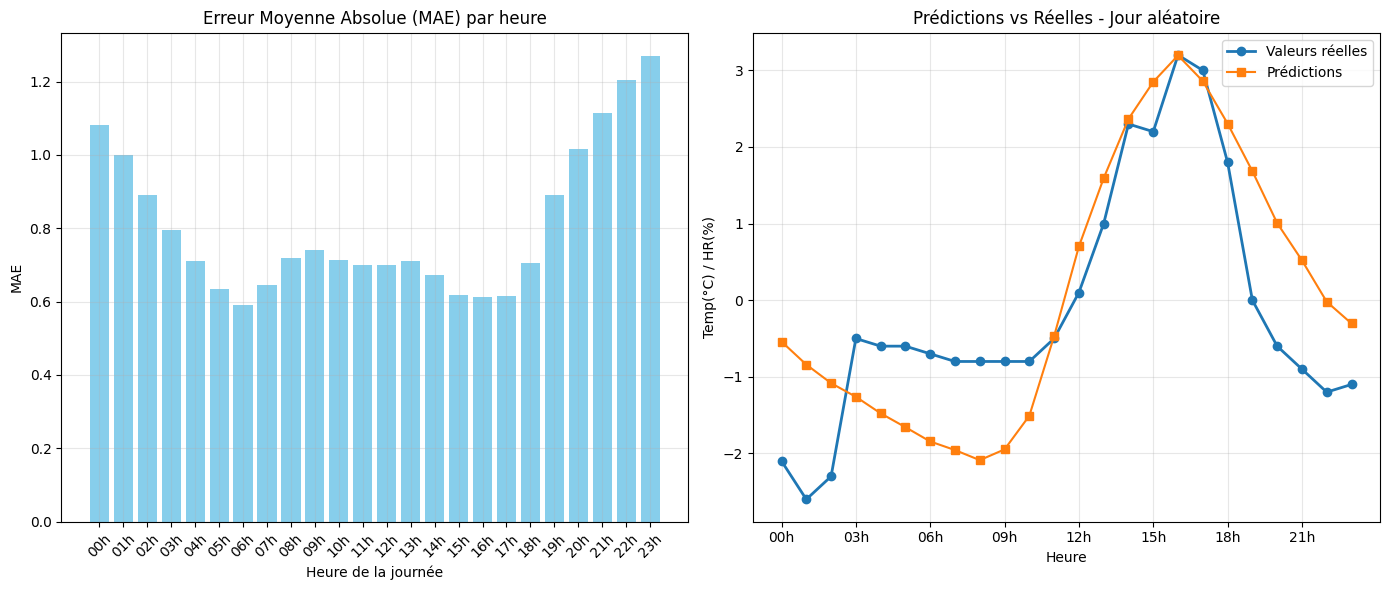


Performance du modèle:
MAE moyen: 0.8064°C
MAE max (à 23h): 1.2696°C
MAE min (à 06h): 0.5900°C


In [49]:
model_temp, hourly_mae_temp = train_and_evaluate_model_temporal_split(X_temp, y_temp, y_scaler_temp, train_model=train_model, evaluate_model=evaluate_model, pred="temp")


Séparation des données:
Train: 5420 échantillons
Test: 1356 échantillons

Début de l'entraînement du modèle...

Entraînement fold 1/5
Taille train: 905, validation: 903
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               2560      
                                                                 
 batch_normalization_10 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_11 (Ba  (None, 128)               512       
 tchNormalizatio

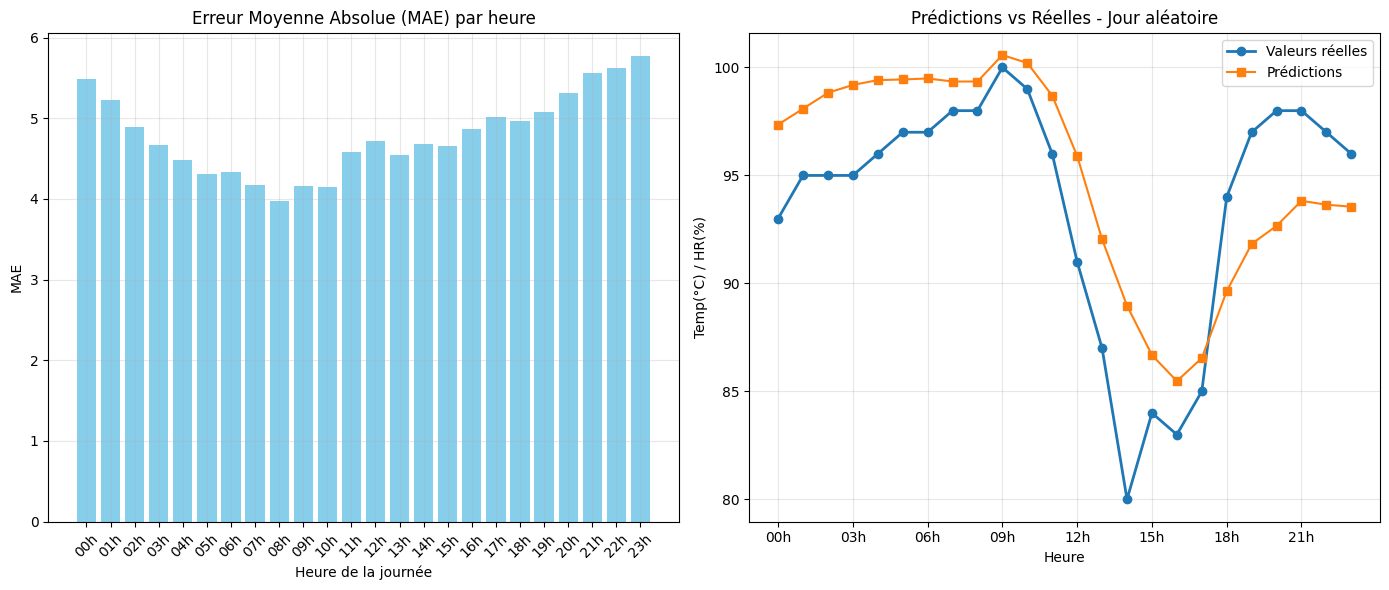


Performance du modèle:
MAE moyen: 4.8006%
MAE max (à 23h): 5.7694%
MAE min (à 08h): 3.9692%


In [50]:
model_hr, hourly_mae_hr = train_and_evaluate_model_temporal_split(X_hr, y_hr, y_scaler_hr, train_model=train_model, evaluate_model=evaluate_model, pred="hr")

In [51]:
def compute_day_stats(temps_array):
    return {
        'min_temp': float(np.min(temps_array)),
        'max_temp': float(np.max(temps_array)),
        'mean_temp': float(np.mean(temps_array)),
        'day_of_year' : temps_array.index.dayofyear[0],
        'month' : temps_array.index.month[0]
    }


Exemple de prédiction...
1/1 [==============================] - 0s 42ms/step


c:\Users\dvesa\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


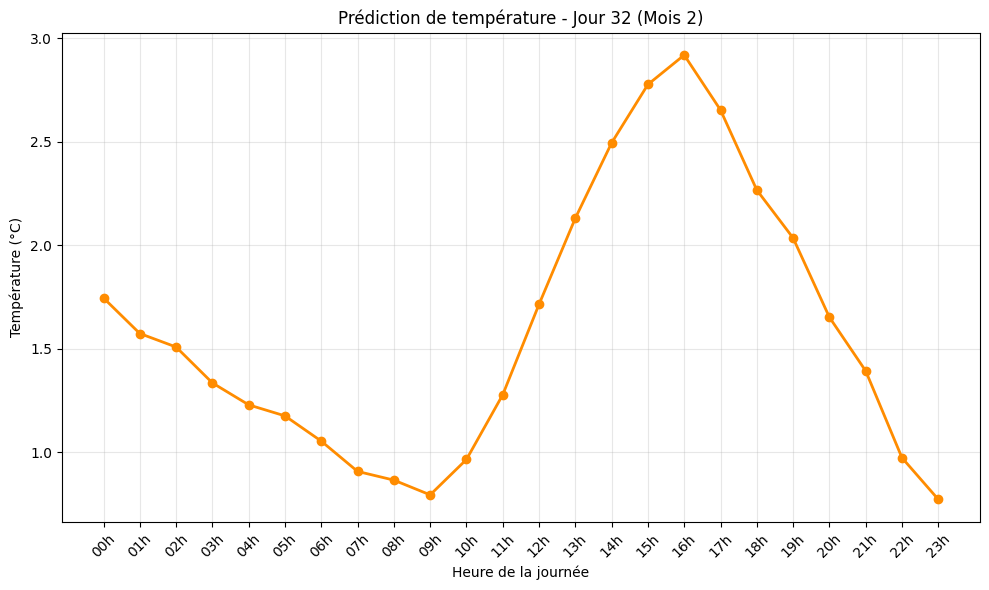

In [52]:
# Fonction de prédiction
def predict_hourly_temperatures(min_temp, max_temp, mean_temp, day_of_year, month, model, X_scaler, y_scaler):
    # Préparation de l'input
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    
    input_data = np.array([[min_temp, max_temp, mean_temp, 
                            day_sin, day_cos, month_sin, month_cos]])
    
    # Transformation
    scaled_input = X_scaler.transform(input_data)
    prediction = model.predict(scaled_input)
    return y_scaler.inverse_transform(prediction)[0]

# Exemple de prédiction
print("\nExemple de prédiction...")

new_day = {
    'min_temp': 0.1,
    'max_temp': 3.0,
    'mean_temp': 1.5125,
    'day_of_year': 32,
    'month': 2
}

predictions = predict_hourly_temperatures(new_day["min_temp"], new_day["max_temp"], new_day["mean_temp"], new_day["day_of_year"], new_day["month"], model_temp, X_scaler_temp, y_scaler_temp)
    
# Visualisation de la prédiction
plt.figure(figsize=(10, 6))
plt.plot(predictions, 'o-', color='darkorange', linewidth=2)
#plt.plot(data_prunay.loc["2015-02-01"]["prunay_Temperature"].values, 'o-', color='red', linewidth=2)
plt.title(f"Prédiction de température - Jour {new_day['day_of_year']} (Mois {new_day['month']})")
plt.xlabel('Heure de la journée')
plt.ylabel('Température (°C)')
plt.xticks(range(24), [f'{h:02d}h' for h in range(24)], rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_example.png', dpi=300)
plt.show()

<Axes: xlabel='time'>

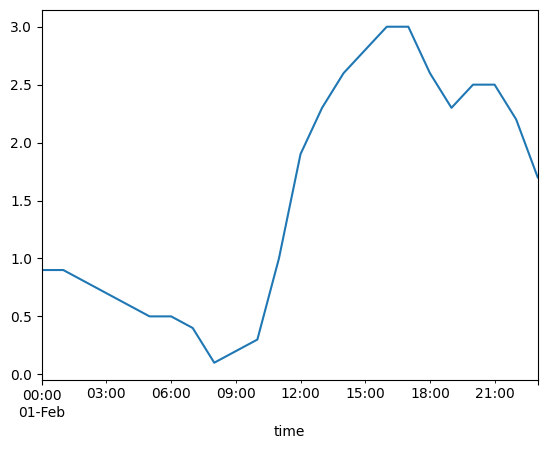

In [53]:
data_prunay.loc["2015-02-01"]["prunay_Temperature"].plot()

In [55]:
compute_day_stats(data_prunay.loc["2015-02-01"]["prunay_RH"])

{'min_temp': 79.0,
 'max_temp': 96.0,
 'mean_temp': 88.20833333333333,
 'day_of_year': 32,
 'month': 2}

In [56]:
compute_day_stats(data_prunay.loc["2015-02-01"]["prunay_Precipitation"])

{'min_temp': 0.0,
 'max_temp': 0.5,
 'mean_temp': 0.14166666666666666,
 'day_of_year': 32,
 'month': 2}

In [57]:
predict_hourly_temperatures(new_day["min_temp"], new_day["max_temp"], new_day["mean_temp"], new_day["day_of_year"], new_day["month"], model_temp, X_scaler_temp, y_scaler_temp)

1/1 [==============================] - 0s 26ms/step


c:\Users\dvesa\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1.75, 1.57, 1.51, 1.34, 1.23, 1.18, 1.05, 0.91, 0.87, 0.79, 0.97,
       1.28, 1.72, 2.13, 2.5 , 2.78, 2.92, 2.65, 2.27, 2.04, 1.65, 1.39,
       0.97, 0.77], dtype=float32)

In [58]:
predictions

array([1.75, 1.57, 1.51, 1.34, 1.23, 1.18, 1.05, 0.91, 0.87, 0.79, 0.97,
       1.28, 1.72, 2.13, 2.5 , 2.78, 2.92, 2.65, 2.27, 2.04, 1.65, 1.39,
       0.97, 0.77], dtype=float32)


Exemple de prédiction...
1/1 [==============================] - 0s 21ms/step


c:\Users\dvesa\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


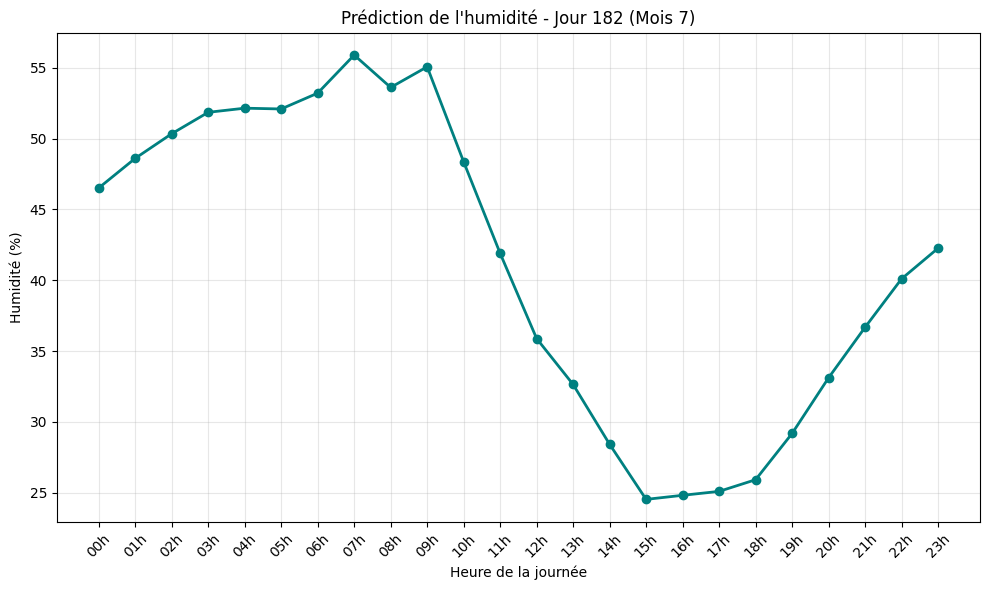

In [59]:
def predict_hourly_hr(prunay_RH_mean, prunay_Temperature_min, prunay_Temperature_max, prunay_Temperature_mean, prunay_Precipitation_mean, day_of_year, month, model, X_scaler, y_scaler):
    # Préparation de l'input
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    input_data = np.array([[prunay_RH_mean, prunay_Temperature_min, prunay_Temperature_max, prunay_Temperature_mean, prunay_Precipitation_mean,
                            day_sin, day_cos, month_sin, month_cos]])

    # Transformation
    scaled_input = X_scaler.transform(input_data)
    prediction = model.predict(scaled_input)
    return y_scaler.inverse_transform(prediction)[0]


# Exemple de prédiction
print("\nExemple de prédiction...")


new_day = {
    'prunay_RH_mean': 50.083333333,       # humidité moyenne journalière (%)
    'prunay_Temperature_min': 20,
    'prunay_Temperature_max': 30.1,
    'prunay_Temperature_mean': 40,
    'prunay_Precipitation_mean' : 0.0375,
    'day_of_year': 182,
    'month': 7,
}

predictions = predict_hourly_hr(new_day["prunay_RH_mean"], new_day["prunay_Temperature_min"], new_day["prunay_Temperature_max"], new_day["prunay_Temperature_mean"], new_day["prunay_Precipitation_mean"], new_day["day_of_year"], new_day["month"], model_hr, X_scaler_hr, y_scaler_hr)

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(predictions, 'o-', color='teal', linewidth=2)
plt.title(f"Prédiction de l'humidité - Jour {new_day['day_of_year']} (Mois {new_day['month']})")
plt.xlabel('Heure de la journée')
plt.ylabel("Humidité (%)")
plt.xticks(range(24), [f'{h:02d}h' for h in range(24)], rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_humidity_example.png', dpi=300)
plt.show()

<Axes: xlabel='time'>

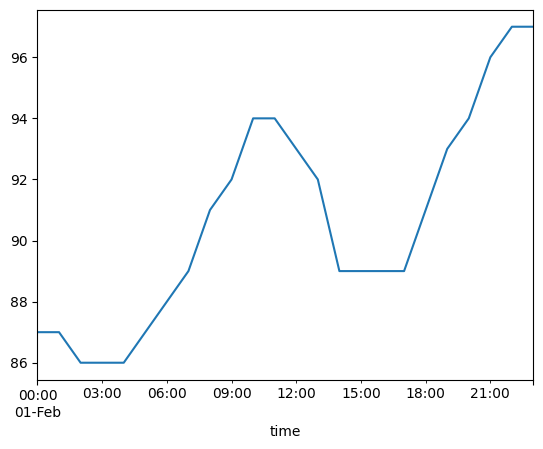

In [60]:
data_prunay.loc["2007-02-01"]["prunay_RH"].plot()

In [61]:
data_prunay.loc["2008-07-01"]["prunay_RH"].min()

51.0

In [62]:
predictions.min()

24.526848

In [63]:
data_prunay.loc["2008-07-01"]["prunay_RH"].max()

92.0

In [64]:
predictions.max()

55.898407

In [67]:
data_prunay.loc["2007-02-01"]["prunay_RH"].mean()

90.66666666666667

In [68]:
predictions.mean()

41.17506

In [69]:
compute_day_stats(data_prunay.loc["2007-07-01"]["prunay_Temperature"])

{'min_temp': 15.9,
 'max_temp': 22.1,
 'mean_temp': 18.870833333333334,
 'day_of_year': 182,
 'month': 7}

In [70]:
compute_day_stats(data_prunay.loc["2007-07-01"]["prunay_RH"])

{'min_temp': 66.0,
 'max_temp': 88.0,
 'mean_temp': 77.08333333333333,
 'day_of_year': 182,
 'month': 7}

In [71]:
compute_day_stats(data_prunay.loc["2007-07-01"]["prunay_Precipitation"])

{'min_temp': 0.0,
 'max_temp': 0.9,
 'mean_temp': 0.0375,
 'day_of_year': 182,
 'month': 7}

In [72]:
data_prunay.loc["2024-07-25"]

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2024-07-25 00:00:00,17.1,75.0,0.0
2024-07-25 01:00:00,16.6,79.0,0.0
2024-07-25 02:00:00,15.3,85.0,0.0
2024-07-25 03:00:00,14.4,87.0,0.0
2024-07-25 04:00:00,14.1,88.0,0.0
2024-07-25 05:00:00,13.7,89.0,0.0
2024-07-25 06:00:00,13.7,91.0,0.0
2024-07-25 07:00:00,15.1,88.0,0.0
2024-07-25 08:00:00,17.3,80.0,0.0


In [73]:
data_prunay

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-01 00:00:00,11.8,91.0,1.0
2007-01-01 01:00:00,11.7,93.0,2.2
2007-01-01 02:00:00,12.0,91.0,1.4
2007-01-01 03:00:00,12.3,90.0,0.4
2007-01-01 04:00:00,12.3,90.0,0.6
...,...,...,...
2025-07-20 22:00:00,19.8,69.0,0.0
2025-07-20 23:00:00,18.6,74.0,0.0
2025-07-21 00:00:00,17.9,75.0,0.0


In [74]:
def predict_from_dataframe_temp(df_input, model, X_scaler, y_scaler):

    # Copie pour éviter d'altérer le DataFrame d'origine
    df = df_input.copy()

    # Ajout des features cycliques
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Features
    features = ['min', 'max', 'mean', 
                'day_sin', 'day_cos', 'month_sin', 'month_cos']

    # Normalisation
    X = X_scaler.transform(df[features])

    # Prédiction
    y_pred_scaled = model.predict(X)

    # Retour à l'échelle originale
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    # Ajout dans le DataFrame sous forme de listes
    df['y_pred'] = [list(row) for row in y_pred]

    return df

In [75]:
def predict_from_dataframe_hr(df_input, model, X_scaler, y_scaler):

    # Copie pour éviter d'altérer le DataFrame d'origine
    df = df_input.copy()

    # Ajout des features cycliques
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Features
    features = ['prunay_RH_mean', 'prunay_Temperature_min', 'prunay_Temperature_max', 'prunay_Temperature_mean', 'prunay_Precipitation_mean',
                'day_sin', 'day_cos', 'month_sin', 'month_cos']

    # Normalisation
    X = X_scaler.transform(df[features])

    # Prédiction
    y_pred_scaled = model.predict(X)

    # Retour à l'échelle originale
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    # Ajout dans le DataFrame sous forme de listes
    df['y_pred'] = [list(row) for row in y_pred]

    return df

In [76]:
data_rcp_2_6predict_hourly_temp = data_rcp_2_6[['tasminAdjust', 'tasmaxAdjust', 'tasAdjust']].copy()

In [77]:
data_rcp_2_6predict_hourly_hr = data_rcp_2_6[['rcp_RH', 'tasminAdjust', 'tasmaxAdjust', 'tasAdjust', 'prtotAdjust']].copy()

In [78]:
data_rcp_2_6predict_hourly_temp

,tasminAdjust,tasmaxAdjust,tasAdjust
Date,,,
2006-01-01,-3.1,4.6,-0.0
2006-01-02,0.2,4.0,2.1
2006-01-03,8.6,9.2,9.0
2006-01-04,9.9,14.2,12.7
2006-01-05,7.6,11.5,9.0
...,...,...,...
2100-12-27,0.7,4.6,2.6
2100-12-28,-0.7,2.5,0.7
2100-12-29,-1.1,1.2,-0.2


In [79]:
data_rcp_2_6predict_hourly_hr

,rcp_RH,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust
Date,,,,,
2006-01-01,93.6,-3.1,4.6,-0.0,0.0
2006-01-02,100.0,0.2,4.0,2.1,8.8
2006-01-03,100.0,8.6,9.2,9.0,0.7
2006-01-04,90.0,9.9,14.2,12.7,0.5
2006-01-05,95.8,7.6,11.5,9.0,0.0
...,...,...,...,...,...
2100-12-27,77.2,0.7,4.6,2.6,0.0
2100-12-28,85.5,-0.7,2.5,0.7,1.0
2100-12-29,95.3,-1.1,1.2,-0.2,0.4


In [80]:
data_rcp_2_6predict_hourly_temp.rename(columns={"tasminAdjust": "min", "tasmaxAdjust": "max", "tasAdjust": "mean"}, inplace=True)

In [81]:
data_rcp_2_6predict_hourly_hr.rename(columns={"rcp_RH": "prunay_RH_mean", "tasminAdjust": "prunay_Temperature_min", "tasmaxAdjust": "prunay_Temperature_max", "tasAdjust": "prunay_Temperature_mean", "prtotAdjust": "prunay_Precipitation_mean"}, inplace=True)

In [82]:
data_rcp_2_6predict_hourly_temp["day_of_year"] = data_rcp_2_6predict_hourly_temp.index.dayofyear
data_rcp_2_6predict_hourly_temp["month"] = data_rcp_2_6predict_hourly_temp.index.month

In [83]:
data_rcp_2_6predict_hourly_hr["day_of_year"] = data_rcp_2_6predict_hourly_hr.index.dayofyear
data_rcp_2_6predict_hourly_hr["month"] = data_rcp_2_6predict_hourly_hr.index.month

In [84]:
data_rcp_2_6predict_hourly_temp = predict_from_dataframe_temp(data_rcp_2_6predict_hourly_temp, model=model_temp, X_scaler=X_scaler_temp, y_scaler=y_scaler_temp)

1085/1085 [==============================] - 1s 991us/step


In [85]:
data_rcp_2_6predict_hourly_hr = predict_from_dataframe_hr(data_rcp_2_6predict_hourly_hr, model=model_hr, X_scaler=X_scaler_hr, y_scaler=y_scaler_hr)

1085/1085 [==============================] - 1s 1ms/step


In [86]:
data_rcp_2_6predict_hourly_hr

,prunay_RH_mean,prunay_Temperature_min,prunay_Temperature_max,prunay_Temperature_mean,prunay_Precipitation_mean,day_of_year,month,day_sin,day_cos,month_sin,month_cos,y_pred
Date,,,,,,,,,,,,
2006-01-01,93.6,-3.1,4.6,-0.0,0.0,1,1,0.0,1.0,0.5,0.9,"[97.08895, 97.7474, 98.43782, 98.74163, 98.953..."
2006-01-02,100.0,0.2,4.0,2.1,8.8,2,1,0.0,1.0,0.5,0.9,"[51.270573, 51.852318, 53.437805, 54.29396, 53..."
2006-01-03,100.0,8.6,9.2,9.0,0.7,3,1,0.1,1.0,0.5,0.9,"[96.5726, 97.54772, 98.62166, 99.15497, 99.924..."
2006-01-04,90.0,9.9,14.2,12.7,0.5,4,1,0.1,1.0,0.5,0.9,"[91.61595, 92.454124, 93.35822, 93.99441, 94.5..."
2006-01-05,95.8,7.6,11.5,9.0,0.0,5,1,0.1,1.0,0.5,0.9,"[97.67296, 98.39351, 99.17529, 99.55814, 99.95..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2100-12-27,77.2,0.7,4.6,2.6,0.0,361,12,-0.1,1.0,-0.0,1.0,"[82.01727, 82.194115, 82.453804, 82.62524, 82...."
2100-12-28,85.5,-0.7,2.5,0.7,1.0,362,12,-0.1,1.0,-0.0,1.0,"[88.03726, 88.49275, 88.90006, 89.13595, 89.48..."
2100-12-29,95.3,-1.1,1.2,-0.2,0.4,363,12,-0.0,1.0,-0.0,1.0,"[94.641266, 95.52468, 96.4997, 97.10305, 97.73..."


In [87]:
data_rcp_2_6predict_hourly_temp

,min,max,mean,day_of_year,month,day_sin,day_cos,month_sin,month_cos,y_pred
Date,,,,,,,,,,
2006-01-01,-3.1,4.6,-0.0,1,1,0.0,1.0,0.5,0.9,"[-1.118983, -1.4261888, -1.6310178, -1.9006164..."
2006-01-02,0.2,4.0,2.1,2,1,0.0,1.0,0.5,0.9,"[2.267031, 2.1962535, 2.135315, 1.9659278, 1.8..."
2006-01-03,8.6,9.2,9.0,3,1,0.1,1.0,0.5,0.9,"[9.389683, 9.39364, 9.341975, 9.387981, 9.3718..."
2006-01-04,9.9,14.2,12.7,4,1,0.1,1.0,0.5,0.9,"[12.13891, 12.187345, 12.142965, 12.134333, 12..."
2006-01-05,7.6,11.5,9.0,5,1,0.1,1.0,0.5,0.9,"[9.132288, 9.086352, 9.021027, 8.981372, 8.919..."
...,...,...,...,...,...,...,...,...,...,...
2100-12-27,0.7,4.6,2.6,361,12,-0.1,1.0,-0.0,1.0,"[2.616882, 2.5119293, 2.4353738, 2.2329104, 2...."
2100-12-28,-0.7,2.5,0.7,362,12,-0.1,1.0,-0.0,1.0,"[0.80836606, 0.6731955, 0.5801, 0.40697604, 0...."
2100-12-29,-1.1,1.2,-0.2,363,12,-0.0,1.0,-0.0,1.0,"[0.18440078, 0.07002034, -0.029477198, -0.1564..."


In [88]:
df_hourly_temp = data_rcp_2_6predict_hourly_temp[["y_pred"]].copy()

In [89]:
df_hourly_hr = data_rcp_2_6predict_hourly_hr[["y_pred"]].copy()

In [90]:
def daily_to_hourly(df, value_col="y"):
    """
    Transforme un DataFrame journalier (1 ligne = 1 jour, 1 cellule = 24 valeurs)
    en DataFrame horaire (1 ligne = 1 heure).
    
    Paramètres :
    ------------
    df : pd.DataFrame
        DataFrame journalier, index = dates, colonne = listes de 24 valeurs horaires.
    value_col : str
        Nom de la colonne contenant les valeurs horaires.

    Retour :
    --------
    df_hourly : pd.DataFrame
        DataFrame horaire, index = datetime (jour + heure), colonnes : ['y']
    """
    df = df.copy()

    # Assurer que l’index est de type datetime
    df.index = pd.to_datetime(df.index)

    # Répéter chaque ligne 24 fois
    df_expanded = df.loc[df.index.repeat(24)].copy()

    # Aplatir les valeurs horaires
    df_expanded[value_col] = df[value_col].explode().values

    # Ajouter les heures (0 à 23)
    df_expanded["hour"] = list(range(24)) * len(df)

    # Créer l’index horaire
    df_expanded["datetime"] = df_expanded.index + pd.to_timedelta(df_expanded["hour"], unit='h')

    # Finaliser
    df_hourly = df_expanded[["datetime", value_col]].set_index("datetime").sort_index()

    return df_hourly


In [91]:
df_hourly_temp = daily_to_hourly(df_hourly_temp, "y_pred")

In [92]:
df_hourly_hr = daily_to_hourly(df_hourly_hr, "y_pred")

In [93]:
df_hourly_temp

,y_pred
datetime,
2006-01-01 00:00:00,-1.1
2006-01-01 01:00:00,-1.4
2006-01-01 02:00:00,-1.6
2006-01-01 03:00:00,-1.9
2006-01-01 04:00:00,-2.2
...,...
2100-12-31 19:00:00,1.4
2100-12-31 20:00:00,1.0
2100-12-31 21:00:00,0.8


In [94]:
df_hourly_hr

,y_pred
datetime,
2006-01-01 00:00:00,97.1
2006-01-01 01:00:00,97.7
2006-01-01 02:00:00,98.4
2006-01-01 03:00:00,98.7
2006-01-01 04:00:00,99.0
...,...
2100-12-31 19:00:00,86.0
2100-12-31 20:00:00,86.8
2100-12-31 21:00:00,88.2


In [95]:
df_hourly_temp.max()

y_pred   48.6
dtype: object

In [96]:
df_hourly_temp.min()

y_pred   -22.5
dtype: object

In [99]:
(df_hourly_temp < -15).sum()

y_pred    107
dtype: int64

In [ ]:
data_prunay["prunay_RH"].loc["2007-07-30"].plot()

In [101]:
df_hourly_hr.max()

y_pred   107.8
dtype: object

In [102]:
df_hourly_hr.min()

y_pred   15.0
dtype: object

In [ ]:
df_hourly_hr.loc["2006-07"]

In [ ]:
df_hourly_temp

In [ ]:
(df_hourly_hr == 91).sum()

In [ ]:
data_prunay

In [ ]:
(data_prunay["prunay_RH"] == 95).sum()

In [ ]:
(df_hourly_hr < 0).sum()

<Axes: xlabel='datetime'>

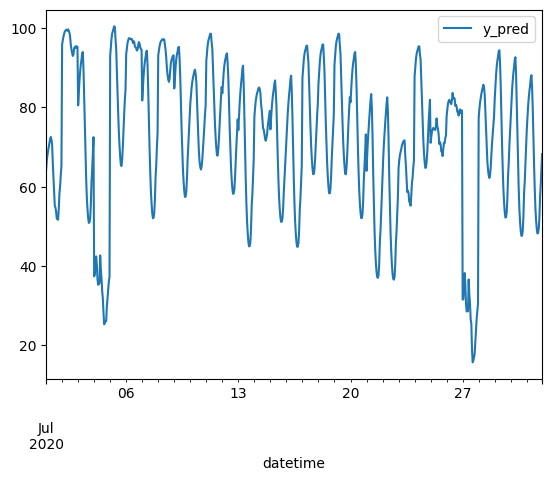

In [104]:
df_hourly_hr.loc["2020-07"].plot()


In [ ]:
df_hourly_hr.loc["2019-07"].plot()

In [ ]:
df_hourly_hr.loc["2022-07"].plot()

In [ ]:
data_rcp_2_6.loc["2006-02-03"]

In [ ]:
plt.figure(figsize=(15, 8))
sns.set_style('darkgrid')

correlation_matrix = round(data_prunay.select_dtypes('number').corr(), 2)

correlation_with_trgt = correlation_matrix['relative_humidity_2m'].sort_values(ascending=False)

ax = sns.barplot(x=correlation_with_trgt.index, y=correlation_with_trgt, palette='viridis')

plt.title('Correlation with meantemp', size= 20)
plt.xlabel('Features')
plt.ylabel('Correlation')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
data_prunay["prunay_RH"]

In [ ]:
plt.figure(figsize=(15, 8))
sns.set_style('darkgrid')

correlation_matrix = round(data_rcp_2_6.select_dtypes('number').corr(), 2)

correlation_with_trgt = correlation_matrix['rcp_RH'].sort_values(ascending=False)

ax = sns.barplot(x=correlation_with_trgt.index, y=correlation_with_trgt, palette='viridis')

plt.title('Correlation with meantemp', size= 20)
plt.xlabel('Features')
plt.ylabel('Correlation')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha='right')

In [105]:
def pourcentages_par_intervalles(array):
    array = np.array(array)
    total = len(array)

    pct_0_30     = np.sum((array >= 0) & (array < 30)) / total * 100
    pct_30_50    = np.sum((array >= 30) & (array < 50)) / total * 100
    pct_50_70    = np.sum((array >= 50) & (array < 70)) / total * 100
    pct_70_90    = np.sum((array >= 70) & (array < 90)) / total * 100
    pct_90_100   = np.sum((array >= 90) & (array < 100)) / total * 100
    pct_eq_100   = np.sum(array == 100) / total * 100
    pct_sup_100  = np.sum(array > 100) / total * 100

    return {
        '0–30%': pct_0_30,
        '30–50%': pct_30_50,
        '50–70%': pct_50_70,
        '70–90%': pct_70_90,
        '90–100%': pct_90_100,
        '==100%': pct_eq_100,
        '>100%': pct_sup_100
    }


In [110]:
pourcentages_par_intervalles(df_hourly_hr)

{'0–30%': 2.8187263434972234,
 '30–50%': 12.150316060483792,
 '50–70%': 20.50274271331681,
 '70–90%': 34.80988337464215,
 '90–100%': 25.247132399561934,
 '==100%': 4.471199108498088,
 '>100%': 0.0}

In [107]:
pourcentages_par_intervalles(data_prunay["prunay_RH"])

{'0–30%': 0.28900490078523244,
 '30–50%': 6.370405898159593,
 '50–70%': 22.28596727480677,
 '70–90%': 43.850037201694676,
 '90–100%': 26.763083620800977,
 '==100%': 0.44150110375275936,
 '>100%': 0.0}

In [108]:
(df_hourly_hr > 100).sum()

y_pred    37234
dtype: int64

In [109]:
df_hourly_hr[df_hourly_hr >= 100] = 100

In [111]:
df_hourly_hr

,y_pred
datetime,
2006-01-01 00:00:00,97.1
2006-01-01 01:00:00,97.7
2006-01-01 02:00:00,98.4
2006-01-01 03:00:00,98.7
2006-01-01 04:00:00,99.0
...,...
2100-12-31 19:00:00,86.0
2100-12-31 20:00:00,86.8
2100-12-31 21:00:00,88.2


In [112]:
df_hourly_temp

,y_pred
datetime,
2006-01-01 00:00:00,-1.1
2006-01-01 01:00:00,-1.4
2006-01-01 02:00:00,-1.6
2006-01-01 03:00:00,-1.9
2006-01-01 04:00:00,-2.2
...,...
2100-12-31 19:00:00,1.4
2100-12-31 20:00:00,1.0
2100-12-31 21:00:00,0.8


In [115]:
data_rcp_2_6_hourly_temp_hr = pd.concat([df_hourly_temp, df_hourly_hr], axis=1)

In [116]:
data_rcp_2_6_hourly_temp_hr

,y_pred,y_pred
datetime,,
2006-01-01 00:00:00,-1.1,97.1
2006-01-01 01:00:00,-1.4,97.7
2006-01-01 02:00:00,-1.6,98.4
2006-01-01 03:00:00,-1.9,98.7
2006-01-01 04:00:00,-2.2,99.0
...,...,...
2100-12-31 19:00:00,1.4,86.0
2100-12-31 20:00:00,1.0,86.8
2100-12-31 21:00:00,0.8,88.2


In [120]:
data_prunay[data_prunay["prunay_Temperature"] < 1] 

,prunay_Temperature,prunay_RH,prunay_Precipitation
time,,,
2007-01-15 04:00:00,0.9,96.0,0.0
2007-01-15 05:00:00,0.7,96.0,0.0
2007-01-15 06:00:00,0.5,95.0,0.0
2007-01-15 07:00:00,0.0,96.0,0.0
2007-01-15 08:00:00,-0.0,96.0,0.0
...,...,...,...
2025-03-17 09:00:00,0.5,80.0,0.0
2025-03-18 06:00:00,0.9,62.0,0.0
2025-03-18 07:00:00,0.4,62.0,0.0
